In [86]:
import sys

import pandas as pd

import superlets_package.superlets

sys.path.insert(0, '..')


In [87]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import importlib
import scipy.signal as signal

import superlets_package.morlet as superlets_module_morlet
import superlets_package.morlet as morlet
import superlets_package.superlets as superlet

#from superlets_package.superlets import wavelet_transform, adaptive_superlet_transform, fdeluca_changing, compute_psd_welch, meanfreq, instant_mean

In [88]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [89]:
importlib.reload(morlet)

<module 'superlets_package.morlet' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/morlet.py'>

# Create simulated EMG signals

#### Baseline parameters

In [90]:
fs = 1024
t = np.linspace(0, 5, 5 * fs)
#noise = np.random.normal(0, 0.01, len(t))  # Gaussian noise
noise = np.zeros(len(t))

### Burst parameters

In [91]:
burst_duration_1 = 1 #seconds
burst_start_1 = 2
MNF_1 = [110.71] 

#### Select method (DeLuca, band-pass filter)

In [92]:
mode = 'DeLuca'
#mode = 'Filter'
#mode = 'Matlab'

### Charge signals generated in Matlab

In [93]:
if mode == 'Matlab':
    burst_1 = pd.read_csv('burst_1s_matlab.csv', header = None)
    burst_1 = burst_1[0]

### Simulated EMG signal with bandpass filter

In [94]:
if mode == 'Filter':
    
    # Create noise
    #MNF_1 = [110.71]  # Central frequency
    bw = 100    # Filter bandwidth
    
    low_cut = 10
    high_cut = 210
    
    plot = True
    
    # We generate gaussian noise
    samples = int(burst_duration_1 * fs)
    t = np.linspace(0, burst_duration_1, samples, endpoint=False)
    gauss_noise = np.random.normal(0, 1, samples)  # Ruido gaussiano de media 0 y varianza 1
    
    # Create and apply filter
    nyquist = fs / 2
    #frec_baja = (MNF_1[0] - bw / 2) / nyquist
    frec_baja = low_cut / nyquist
    #frec_alta = (MNF_1[0] + bw / 2) / nyquist
    frec_alta = high_cut / nyquist
    # Diseñar filtro paso banda Butterworth
    b, a = signal.butter(N=4, Wn=[frec_baja, frec_alta], btype='band')
    burst_1 = signal.filtfilt(b, a, gauss_noise)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(t, gauss_noise)
        plt.title("Gaussian noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.subplot(2, 1, 2)
        plt.plot(t, burst_1, color='orange')
        plt.title(f"Filtered noise")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    w, h = signal.freqz(b, a, worN=8000)  # worN determina el número de puntos a evaluar

    # Graficar respuesta en frecuencia
    plt.figure()
    plt.plot(w * nyquist / np.pi, 20 * np.log10(abs(h)), label="Respuesta en Frecuencia")
    plt.title("Respuesta en Frecuencia del Filtro Butterworth")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud (dB)")
    plt.grid()
    plt.legend()
    plt.show()


### Simulated EMG signal: Modelo de DeLuca

In [95]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

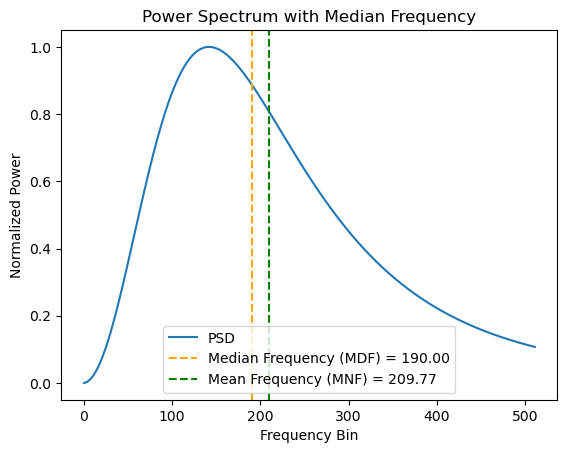

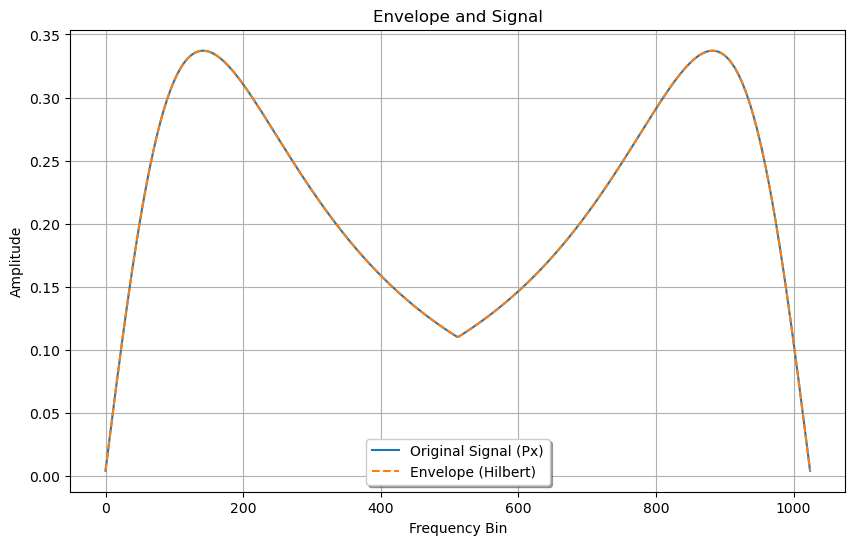

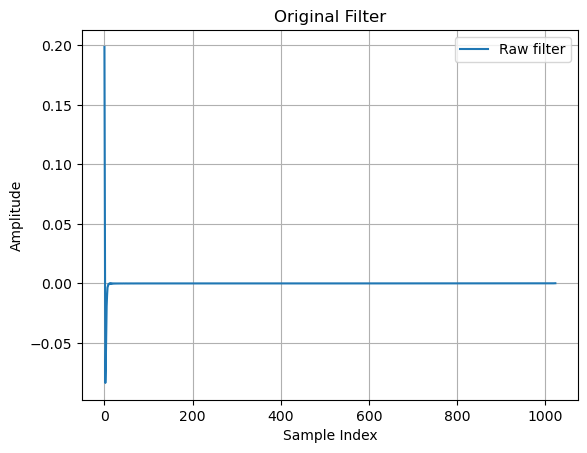

In [96]:
if mode == 'DeLuca':
    burst_1 = []
    #[filtro, Pdeluca, burst_1] = superlet.fdeluca(72, 110, 1024, burst_duration_1, plot = True)
    [filtro, Pdeluca, burst_1, MNF, MNF_analytic] = superlet.fdeluca(40, 20, fs, burst_duration_1, plot = True)
    f = np.arange(0, fs / 2)
    MNF_IDEAL = superlet.meanfreq(Pdeluca,f)
    MNF_1 = [MNF_IDEAL]
    # bw = 100
    # nyquist = fs / 2
    # frec_baja = (MNF_1[0] - bw / 2) / nyquist
    # frec_alta = (MNF_1[0] + bw / 2) / nyquist
    # # Diseñar filtro paso banda Butterworth
    # b, a = signal.butter(N=4, Wn=[frec_baja, frec_alta], btype='band')
    # burst_1 = signal.filtfilt(b, a, burst_1)

In [ ]:
MNF_analytic

In [ ]:
MNF

In [ ]:
MNF_1

In [97]:
# burst_1 = []
# # if mode == 'DeLuca':   
# [Pxx_1, burst_1, MNF_1, MDF_1] = superlet.fdeluca_changing(80, 120, 60, 100, fs, T = burst_duration_1, wind_change = burst_duration_1, plot = True)
# #     # nyquist = 0.5 * fs
#     # low = 20 / nyquist
#     # high = 300 / nyquist
#     # b, a = signal.butter(N=4, Wn=[low, high], btype='band')  # Filtro pasa banda
#     # burst_1 = signal.filtfilt(b, a, burst_1)

#### Add noise to the signal with a particular value for SNR

In [98]:
# def add_wgn_to_sig(signal, w_g_noise, ssnnrr):
#     
#     sign_UnitaryVar = (signal - np.mean(signal)) / np.std(signal)
#     Pn = np.var(w_g_noise)
#     Ps = Pn * (10**(ssnnrr / 10))
#     new_signals = np.sqrt(Ps) * sign_UnitaryVar
#     noisy_signal = new_signals + w_g_noise
# 
#     return noisy_signal


In [99]:
import numpy as np
import matplotlib.pyplot as plt

def add_noise(x, snr, plot = False):
    """
    Add Gaussian random noise to a signal with a specified SNR.

    Parameters:
        x (numpy array): Original signal (vector)
        snr (float): Desired Signal-to-Noise Ratio (in dB)

    Returns:
        numpy array: Signal with added Gaussian noise
    """
    n = len(x)  # Length of the signal
    Px = np.sum(np.abs(x)**2) / n  # Power of the original signal
    Pn = Px / (10**(snr / 10))  # Noise power for the given SNR

    noise = np.sqrt(Pn) * np.random.randn(*x.shape)  # Generate Gaussian noise
    xn = x + noise  # Add noise to the original signal

    # Plot the original and noisy signals
    if plot:
        plt.figure()
        plt.plot(xn, 'r', label='Noisy Signal')
        plt.plot(x, 'b', label='Original Signal')
        plt.legend()
        plt.title(f'Signal with Added White Gaussian Noise (SNR = {snr} dB)')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

    return xn

### We add burst to baseline signal

In [100]:
baseline_1 = noise.copy()
baseline_1[burst_start_1*fs:burst_start_1*fs + len(burst_1)] += burst_1

In [101]:
# burst_duration_2 = 3
# burst_start_2 = 5
# 
# [Pxx_2, burst_2, MNF_2, MDF_2] = superlet.fdeluca_changing(100, 140, 80, 120, fs, burst_duration_2, 0.125, plot = True)
# # t_2 = np.linspace(0, burst_duration_2, len(burst_2))
# # plt.plot(t_2, burst_2)
# # plt.title('Burst 2')
# # 
# plt.figure()
# psd_welch, f_welch = superlet.compute_psd_welch(burst_2, fs, plot=True, muscle='Burst 2')
# 
# baseline_1[burst_start_2*fs:burst_start_2*fs + len(burst_2)] += burst_2
# # plt.figure()
# # plt.plot(baseline_1)
# # plt.title('Baseline + Burst 2')

In [102]:
# # High frequency and very fast burst
# burst_duration_3 = 0.5
# burst_start_3 = 8.5
# 
# [Pxx_3, burst_3, MNF_3, MDF_3] = superlet.fdeluca_changing(220, 250, 200, 230, fs, burst_duration_3, 0.125, plot = False)
# # t_3 = np.linspace(0, burst_duration_3, len(burst_3))
# # plt.plot(t_3, burst_3)
# # plt.title('Burst 3')
# # 
# # plt.figure()
# psd_welch, f_welch = superlet.compute_psd_welch(burst_3, fs, plot=True, muscle='Burst 3')
# 
# baseline_1[int(burst_start_3 * fs):int(burst_start_3 * fs + len(burst_3))] += burst_3
# # plt.figure()
# # plt.plot(baseline_1)
# # plt.title('Baseline + Burst 3')

### Signal visualization

Reference mean frequency: 209.772184485205 Hz


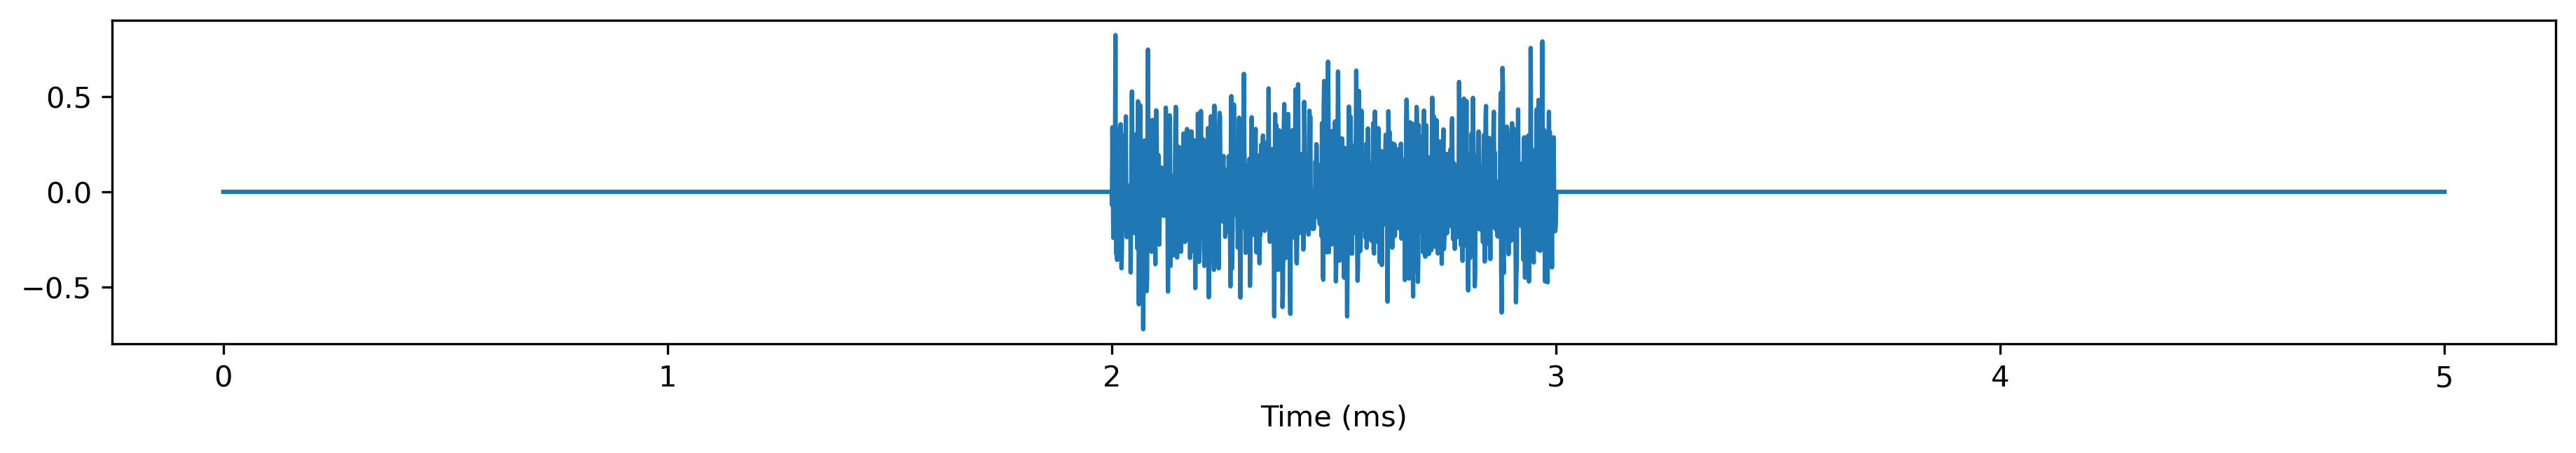

In [103]:
signal = jnp.array(baseline_1)
#signal = burst_signal
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1[0]} Hz")

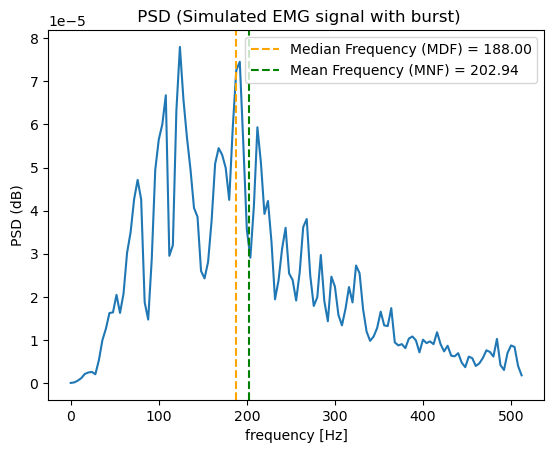

In [104]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

We first apply regular wavelet transforms to the signal, with wavelets of 3, 16 and 33 cycles long, respectively. Note that we specifically use the complex Morlet wavelet for both the wavelet and superlet transforms.

In [105]:
def calculate_mae(estimates, true_value):
    errors = np.abs(np.array(estimates) - true_value)
    mae = np.mean(errors)
    std_error = np.std(np.array(estimates))
    return mae, std_error

In [106]:
freqs = np.linspace(20,500,512) # Número de puntos del vector frecuencia

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [107]:
importlib.reload(morlet)

<module 'superlets_package.morlet' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/morlet.py'>

In [108]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [109]:
plot_1 = False
plot_2 = False

In [110]:
MNF_1

[209.772184485205]

In [111]:
offset = 0 # Para que la figura del instant mean frequency sea más mona
offset_burst = 0

260.01608
254.833
255.40146
256.36423
256.54938


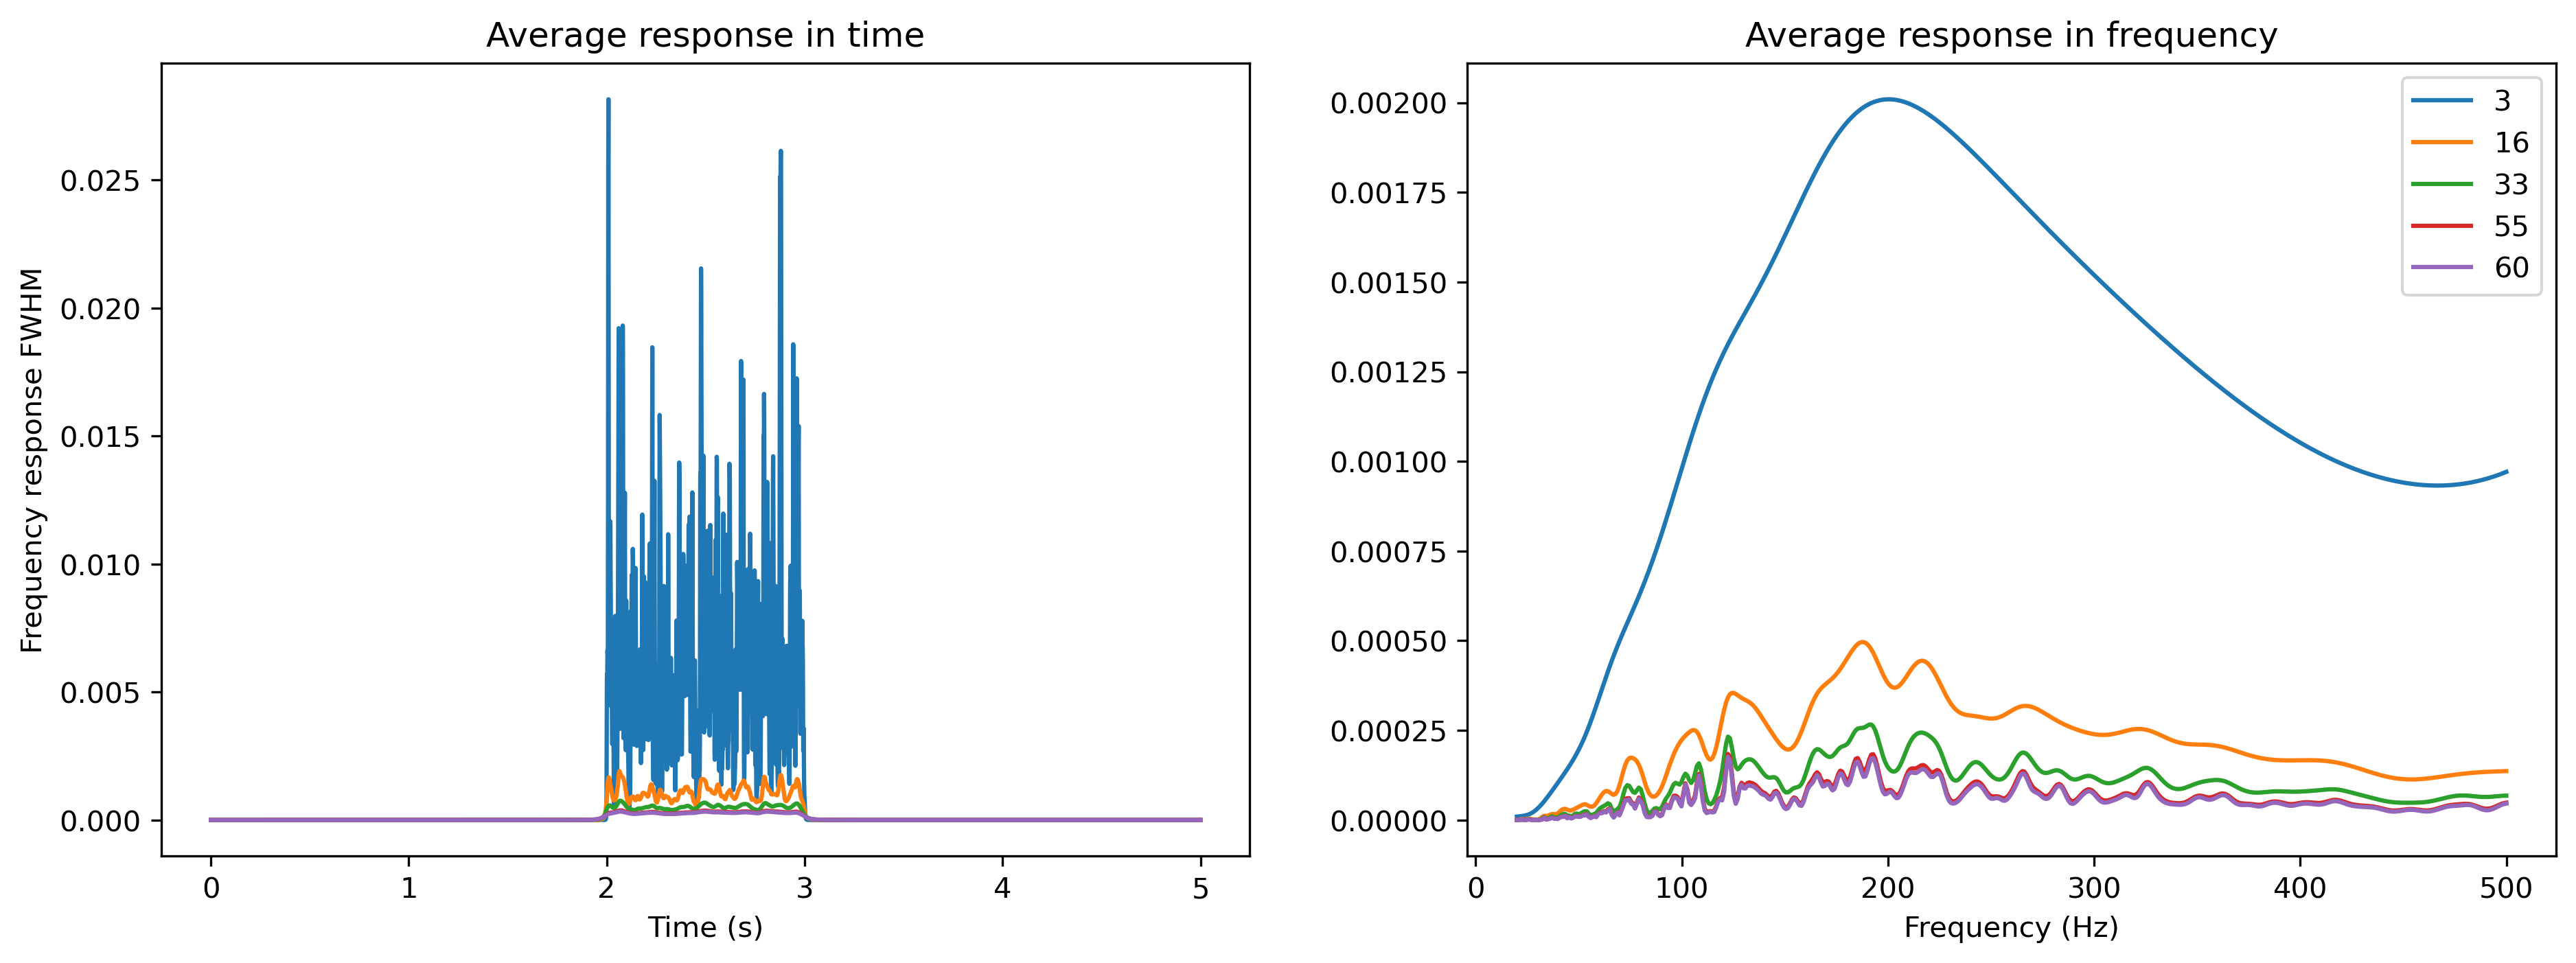

In [112]:
#params_wavelet = [3, 16, 33, 55, 60, 115]
params_wavelet = [3, 16, 33, 55, 60]
#params_wavelet = [3, 33, 60, 160, 220, 400]

if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(15, 5), dpi=300)

if plot_2:
    # Definir límites de color para que sean iguales en todos los subplots
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet = []
std_wavelet = []
times_wavelet = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

for i, c in enumerate(params_wavelet):
    import time
    start_time = time.time()
    [wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)
    end_time = time.time()
    times_wavelet.append(end_time - start_time)
    #[wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)  
    
    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram)**2, aspect='auto', cmap="jet", interpolation="none", origin="lower", extent=[0, len(signal)/fs, freqs[0], freqs[-1]]) #, vmin=vmin, vmax=vmax)
        end_time = time.time()
        times_wavelet.append(end_time - start_time)
        ax[i].set_title(f"Cycles: {c}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")
        
        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        #plt.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 1, wspace = 0.5)
        plt.tight_layout()  
    
    #mean_freq = sum(power.*frequencies)/sum(power)
    #instant_mean.append(meanfreq(scalogram[:, col], freqs) for col in range(scalogram.shape[1]))
    
    scalogram_2 = jnp.abs(scalogram)**2    
    

    total_scalogram_wavelet.append(scalogram_2)  
    #instant_mean_freq_total = []
    
    #instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)    
    instant_mean_freq_total = []

    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_mean_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)

    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)
    # plt.figure()
    # plt.plot(instant_mean_freq_total)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {c})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet.append(mae)
    std_wavelet.append(std)

    # Compute MAE in time
    # freq_tolerance = 10
    # time_support = (instant_mean_freq_total >= MNF_1[0] - freq_tolerance) & (instant_mean_freq_total <= MNF_1[0] + freq_tolerance)
    # detected_times = tiempo[time_support]
    # detected_start = detected_times[0] if len(detected_times) > 0 else None
    # detected_end = detected_times[-1] if len(detected_times) > 0 else None
    # 
    # if detected_start is not None and detected_end is not None:
    #     errors = [abs(burst_start_1 - detected_start), abs((burst_start_1 + burst_duration_1) - detected_end)]
    #     # Calcular MAE
    #     mae_time = np.mean(errors)
    #     # Calcular STD
    #     std_time = np.std(errors)
    # else:
    #     mae_time = float('nan')  # No se detectó el burst correctamente
    #     std_time = float('nan')
    #     
    # mae_superlet_t.append(mae_time)
    # std_superlet_t.append(std_time) 

    
    time = np.arange(scalogram_2.shape[1]) / fs
    
    total_time.append(time)
    total_freq.append(freqs)

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
    
res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [113]:
mae_wavelet

[57.225514937152056,
 45.14197056417272,
 45.62925914525192,
 46.59204213916462,
 46.7772077977578]

### Wavelet visualization

In [114]:
# import matplotlib.pyplot as plt
# 
# # Supongamos que la frecuencia central de cada wavelet varía en un rango de frecuencias
# frequencies = jnp.linspace(1, 50, 141)  # Por ejemplo, de 1 a 50 Hz con 141 frecuencias
# 
# # Define un vector de tiempo
# t = jnp.linspace(-1, 1, 2048)  # Tiempo con 2048 puntos
# 
# # Grafica la wavelet para una frecuencia específica (por ejemplo, la frecuencia central de 20 Hz)
# freq_idx = 70  # Índice de frecuencia alrededor de la mitad del rango
# plt.plot(t, jnp.real(wv[freq_idx]), label=f'Wavelet en {frequencies[freq_idx]:.2f} Hz')
# plt.xlabel("Tiempo (s)")
# plt.ylabel("Amplitud")
# plt.title("Parte Real de la Wavelet Morlet a una Frecuencia Específica")
# plt.xlim(-1.3, 1.3)
# plt.legend()
# plt.show()



In [115]:
# plt.imshow(jnp.abs(wv), aspect='auto', extent=[-1, 1, frequencies[-1], frequencies[0]], cmap='viridis')
# plt.colorbar(label="Amplitud")
# plt.xlabel("Tiempo (s)")
# plt.ylabel("Frecuencia (Hz)")
# plt.title("Representación Tiempo-Frecuencia de la Wavelet")
# plt.show()


There's a tradeoff above; using a low number of cycles results in high temporal resolution, but poor frequency resolution (the activations are "smeared" on the frequency dimension). On the other hand, a high number of cycles results in high frequency resolution, but poor temporal resolution. 

There are fundamental limits to how precise we can be on *both* aspects without making a tradeoff on either (the Gabor limit), but the standard wavelet transform isn't on that optimal boundary. Superlets improve resolution on both (time *and* frequency) by taking the geometric mean of wavelet transforms of different cycle lengths, more tightly approaching the Gabor limit.

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [116]:
plot_1 = False
plot_2 = False

In [117]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [118]:
mae_wavelet

[57.225514937152056,
 45.14197056417272,
 45.62925914525192,
 46.59204213916462,
 46.7772077977578]

221.12544233794364
221.42691308902502
210.1291959141421
206.51126971767286
204.54697085003033


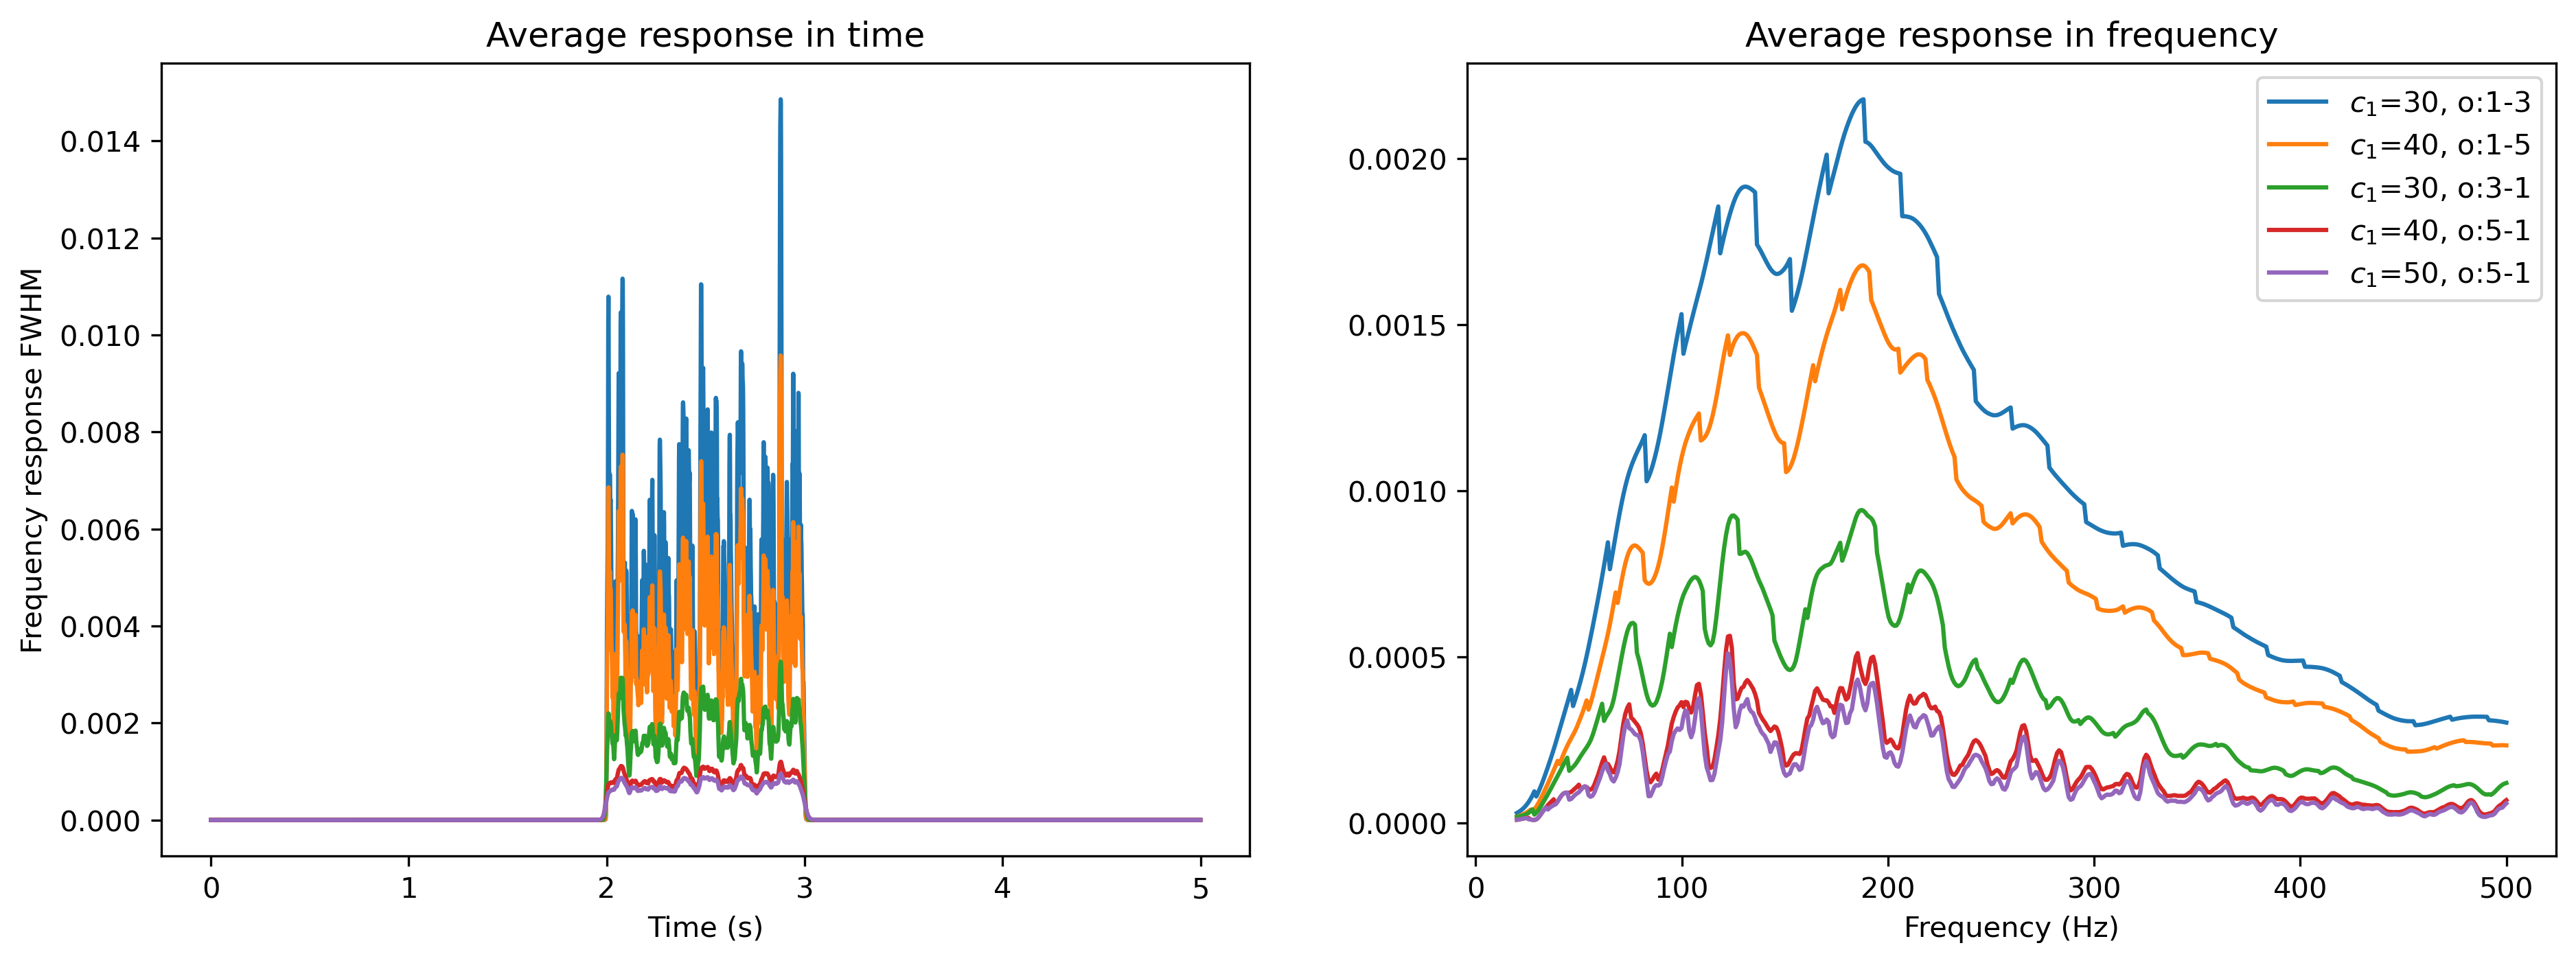

In [119]:
#params_superlet = [[3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]]
params_superlet = [[1, 1, 3, 5, 5], [3, 5, 1, 1, 1], [30, 40, 30, 40, 50]]
#params_superlet = [[3,5,1],[1,1,5],[30,30,40]]

if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet = []
std_superlet = []

mae_superlet_t = []
std_superlet_t = []

times_superlet = []

total_time = []
total_freq = []

total_scalogram_superlet = []

#enumerate(zip([3,5,1], [1,1,5], [30,30,40])):
#enumerate(zip([1,1,1], [10,20,30], [100,100,200])):
for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):
    import time

    start_time = time.time()
    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    end_time = time.time()
    times_superlet.append(end_time - start_time)

    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2

    if np.any(np.isnan(jnp.abs(scalogram) ** 2)) or np.any(np.isinf(jnp.abs(scalogram) ** 2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram) ** 2)

    total_scalogram_superlet.append(scalogram_2)
    #scalogram_2 = scalogram_2 * freqs[:, np.newaxis]  

    # Compute MAE in frequency
    instant_mean_freq_total = []

    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_mean_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)

    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)
    # plt.figure()
    # plt.plot(instant_mean_freq_total)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet.append(mae)
    std_superlet.append(std)

    # Compute MAE in time
    # freq_tolerance = 10
    # time_support = (instant_mean_freq_total >= MNF_1[0] - freq_tolerance) & (instant_mean_freq_total <= MNF_1[0] + freq_tolerance)
    # detected_times = tiempo[time_support]
    # detected_start = detected_times[0] if len(detected_times) > 0 else None
    # detected_end = detected_times[-1] if len(detected_times) > 0 else None
    # 
    # if detected_start is not None and detected_end is not None:
    #     errors = [abs(burst_start_1 - detected_start), abs((burst_start_1 + burst_duration_1) - detected_end)]
    #     # Calcular MAE
    #     mae_time = np.mean(errors)
    #     # Calcular STD
    #     std_time = np.std(errors)
    # else:
    #     mae_time = float('nan')  # No se detectó el burst correctamente
    #     std_time = float('nan')
    #     
    # mae_superlet_t.append(mae_time)
    # std_superlet_t.append(std_time) 

    
    time = np.arange(scalogram_2.shape[1]) / fs
    
    total_time.append(time)
    total_freq.append(freqs)

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
    
res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])

In [120]:
mae_superlet

[25.065640185637655,
 22.646761319356372,
 15.812546399566742,
 11.605110089064107,
 11.07933383058543]

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [121]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [122]:
offset_burst = 20
offset = 0

207.85251
204.3718
203.89758
203.89522
203.90282


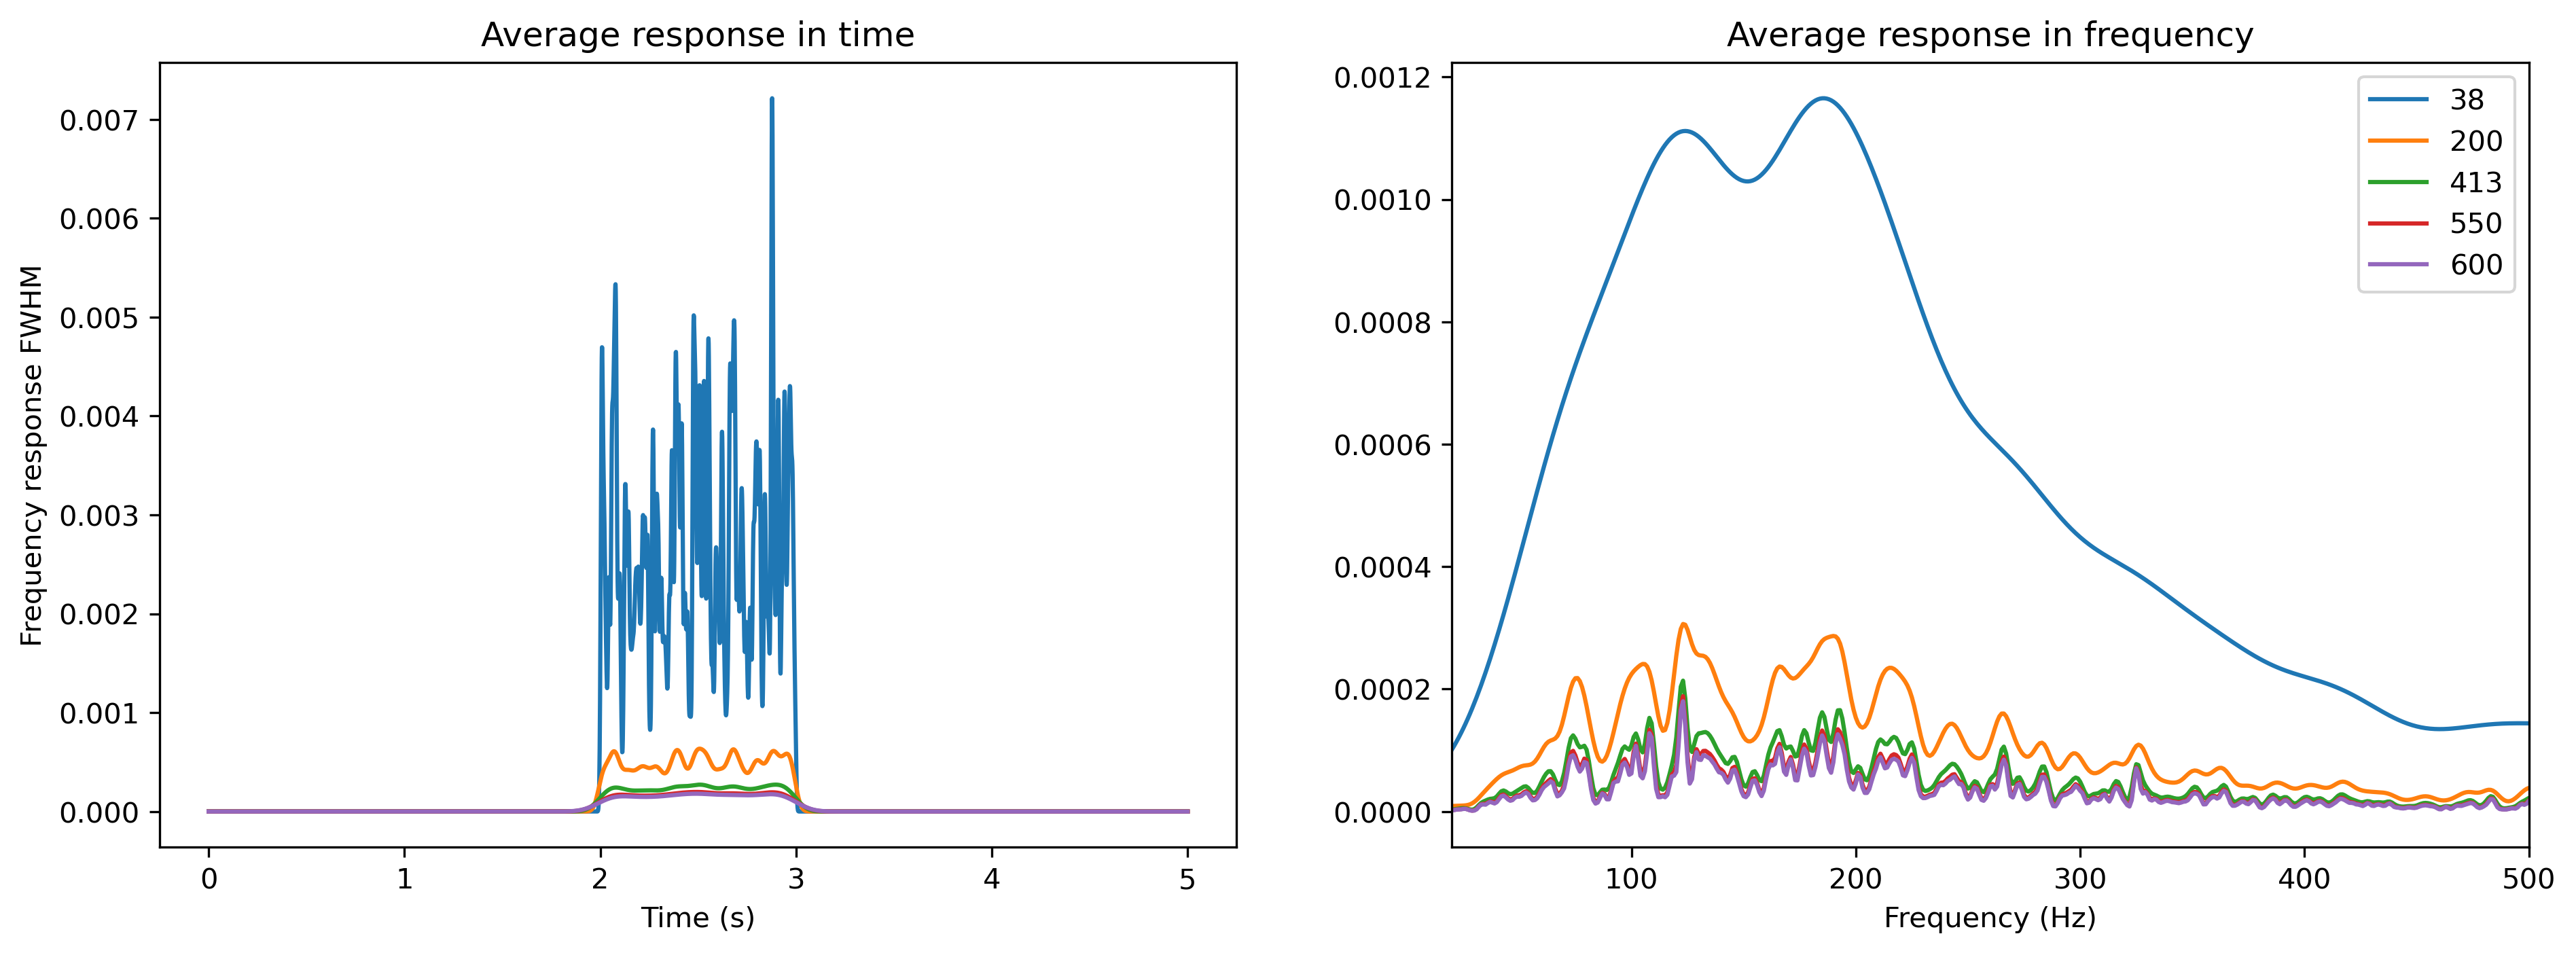

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.signal import windows

# Parámetros de la STFT con ventanas de 38 ms, 200 ms, y 413 ms (convertido a muestras)
# [38, 200, 413, 550, 600, 824]
windows_ms = [38, 200, 413, 550, 600]
#windows_samples = [int((w / 1000) * fs) for w in windows_ms]  # Convertir a muestras

if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft = []
std_stft = []
times_stft = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    import time
    # Calcular la ventana Blackman
    start_time = time.time()
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    # Dimensión de la frecuencia = nfft/2 + 1
    # Dimesión del tiempo = [(N - noverlap)/(nperseg-noverlap)] + 1 = 
    
    # Realizar la STFT con la ventana Blackman y superposición del 50%
    #f, t, Zxx = stft(signal, fs, window=window, nfft=nfft, nperseg=w, noverlap=w//2, padded=True, scaling='psd')
    f, t, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    
    # ax[i].pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')
    
    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    # Graficar la representación de potencia
    #plt.figure(figsize=(10, 6))
    
    end_time = time.time()
    times_stft.append(end_time - start_time)
    
    if plot_1:
        pcm = ax[i].pcolormesh(t,f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
    
    scalogram_2 = Zxx_power
    
    #if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
    scalogram_2 = jnp.nan_to_num(jnp.abs(Zxx)**2, nan=0.0, posinf=0.0, neginf=0.0)
        
    total_scalogram_stft.append(scalogram_2)
 
    instant_mean_freq_total = []   
    instant_mean_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)    
    
    #mean_instant_freq = np.where(freqs,np.max(scalogram_2, axis=0))
    # mean_instant = np.mean(np.where(freqs,max(scalogram_2)))
    # plt.figure()
    # plt.plot(mean_instant)
    
    start_index = np.argmin(np.abs(t - burst_start_1))
    end_index_burst = np.argmin(np.abs(t - (burst_start_1 + burst_duration_1)))
    
    # Segmento inicial antes del burst
    initial_imnf = instant_mean_freq[:max(0, start_index - offset)]  # Asegurar que no haya índices negativos
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)
    
    # Segmento durante el burst
    instant_mean_freq_burst = instant_mean_freq[start_index:end_index_burst]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]  # Aplicar offset dentro del burst
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)
    
    # Segmento final después del burst
    final_start_index = end_index_burst + offset
    final_imnf = instant_mean_freq[final_start_index:]
    instant_mean_freq_total.extend(final_imnf)
  
    # initial_imnf = instant_mean_freq[:np.where(t >= burst_start_1)[0][0]-offset]
    # instant_mean_freq_total.extend(initial_imnf)
    # # plt.figure()
    # # plt.plot(initial_imnf)
    # 
    # print(t >= (burst_start_1 + burst_duration_1))
    # instant_mean_freq_burst = instant_mean_freq[np.where(t >= burst_start_1)[0][0]:np.where(t >= (burst_start_1 + burst_duration_1))[0][0]]
    # instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    # instant_mean_freq_total.extend(instant_mean_freq_burst)
    # # plt.figure()
    # # plt.plot(instant_mean_freq_burst)
    #  
    # final_imnf = instant_mean_freq[np.where(t >= burst_start_1 + burst_duration_1)[0][0] + offset:]
    # instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.linspace(t[0], t[-1], len(instant_mean_freq_total))
    
    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total, label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')
        
        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)
        
        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")
    
    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft.append(mae)
    std_stft.append(std)
    
    total_time.append(np.linspace(t[0], t[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [124]:
mae_stft

[25.194374995346042,
 12.10240184481895,
 9.09830331401613,
 8.426831299215147,
 8.26096994329642]

In [125]:
if 'SNR' not in globals():
    SNR = "Inf"

### Plot comparison of the same SNR

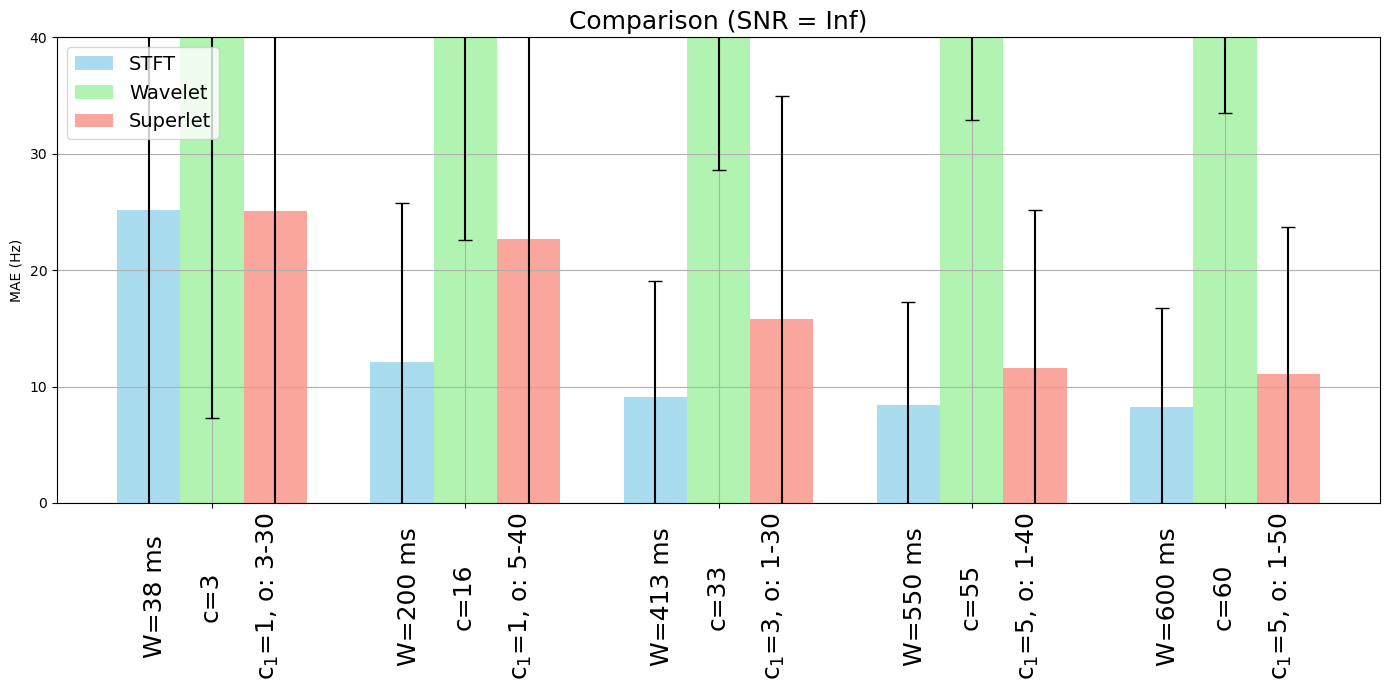

In [127]:
# params_wavelet = [3, 16, 33, 55, 60, 115]
# params_superlet = [
#     (3, 1, 30), (5, 1, 30), (1, 5, 40), (1, 10, 100), (1, 20, 100), (1, 30, 200)
# ]
# params_stft = [38, 200, 413, 550, 600, 824]  # Tamaños de ventana en ms
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft, width=bar_width, yerr=std_stft, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet, width=bar_width, yerr=std_wavelet, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet, width=bar_width, yerr=std_superlet, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 41, 10))

plt.ylabel('MAE (Hz)')
plt.title('Comparison (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,40)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

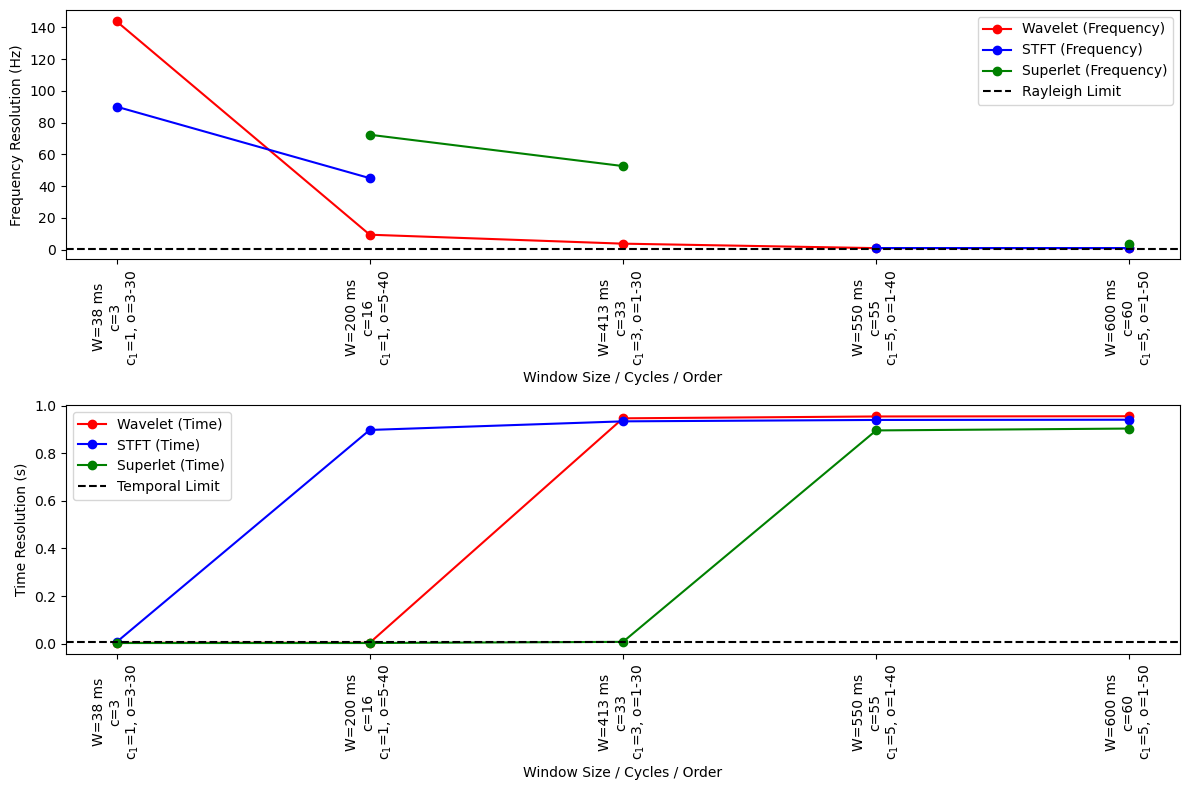

In [85]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = np.arange(1,len(params_wavelet)+1)

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

# Only first time!!!!

In [ ]:
MAES = {
    'stft': [],
    'wavelet': [],
    'superlet': [],
    'std_stft': [],
    'std_wavelet': [],
    'std_superlet': []
}

In [ ]:
MAES['wavelet'].append(mae_wavelet)
MAES['stft'].append(mae_stft)
MAES['superlet'].append(mae_superlet)
MAES['std_wavelet'].append(std_wavelet)
MAES['std_stft'].append(std_stft)
MAES['std_superlet'].append(std_superlet)

In [ ]:
MAES

### WE REPEAT EVERYTHING WITH DIFFERENT SNR

## We reset the signal

# Baseline parameters

In [ ]:
fs = 1024
t = np.linspace(0, 5, 5 * fs)
noise = np.random.normal(0, 0.01, len(t))  # Gaussian noise
#noise = np.zeros(len(t))
baseline_1 = noise.copy()

In [ ]:
baseline_1[burst_start_1*fs:burst_start_1*fs + len(burst_1)] += burst_1

In [ ]:
signal = baseline_1
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1[0]} Hz")

In [ ]:
SNR = 5
#signal_noise = add_noise(baseline_1, SNR, plot = True)
signal_noise = add_noise(signal, SNR, plot = True)
#signal_noise = add_wgn_to_sig(baseline_1, noise, SNR)
signal = signal_noise

In [ ]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal)/fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1} Hz")

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [ ]:
importlib.reload(superlet)

In [ ]:
#params_wavelet = [3, 16, 33, 55, 60, 115]

if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(15, 5), dpi=300)

if plot_2:
    # Definir límites de color para que sean iguales en todos los subplots
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet = []
std_wavelet = []
times_wavelet = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

for i, c in enumerate(params_wavelet):
    import time

    start_time = time.time()
    [wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)
    end_time = time.time()
    times_wavelet.append(end_time - start_time)
    #[wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)  

    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",
                          extent=[0, len(signal) / fs, freqs[0], freqs[-1]])  #, vmin=vmin, vmax=vmax)
        end_time = time.time()
        times_wavelet.append(end_time - start_time)
        ax[i].set_title(f"Cycles: {c}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        #plt.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 1, wspace = 0.5)
        plt.tight_layout()

        #mean_freq = sum(power.*frequencies)/sum(power)
    #instant_mean.append(meanfreq(scalogram[:, col], freqs) for col in range(scalogram.shape[1]))

    scalogram_2 = np.abs(scalogram) ** 2

    if np.any(np.isnan(jnp.abs(scalogram) ** 2)) or np.any(np.isinf(jnp.abs(scalogram) ** 2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram) ** 2)

    total_scalogram_wavelet.append(scalogram_2)
    instant_mean_freq_total = []

    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_mean_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)

    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {c})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet.append(mae)
    std_wavelet.append(std)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [ ]:
mae_wavelet

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [ ]:
importlib.reload(superlet)

In [ ]:
#params_superlet = [[3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]]
#params_superlet = [[3,5,1],[1,1,5],[30,30,40]]

if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet = []
std_superlet = []
times_superlet = []

total_time = []
total_freq = []

total_scalogram_superlet = []

#enumerate(zip([3,5,1], [1,1,5], [30,30,40])):
#enumerate(zip([1,1,1], [10,20,30], [100,100,200])):
for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):
    import time

    start_time = time.time()
    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    end_time = time.time()
    times_superlet.append(end_time - start_time)

    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",
                          extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2

    if np.any(np.isnan(jnp.abs(scalogram) ** 2)) or np.any(np.isinf(jnp.abs(scalogram) ** 2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram) ** 2)

    total_scalogram_superlet.append(scalogram_2)
    #scalogram_2 = scalogram_2 * freqs[:, np.newaxis]  

    instant_mean_freq_total = []

    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_mean_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)

    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet.append(mae)
    std_superlet.append(std)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq,
                                                        [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in
                                                         zip(*params_superlet)])

In [ ]:
mae_superlet

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [ ]:
importlib.reload(superlet)

In [ ]:
# Parámetros de la STFT con ventanas de 38 ms, 200 ms, y 413 ms (convertido a muestras)
# [38, 200, 413, 550, 600, 824]

#windows_samples = [int((w / 1000) * fs) for w in windows_ms]  # Convertir a muestras

if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft = []
std_stft = []
times_stft = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    import time

    # Calcular la ventana Blackman
    start_time = time.time()
    window = windows.blackman(w)

    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    # Dimensión de la frecuencia = nfft/2 + 1
    # Dimesión del tiempo = [(N - noverlap)/(nperseg-noverlap)] + 1 = 

    # Realizar la STFT con la ventana Blackman y superposición del 50%
    #f, t, Zxx = stft(signal, fs, window=window, nfft=nfft, nperseg=w, noverlap=w//2, padded=True, scaling='psd')
    f, t, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w - 1, nfft=nfft, detrend=False,
                     return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')

    # ax[i].pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')

    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2

    # Graficar la representación de potencia
    #plt.figure(figsize=(10, 6))

    end_time = time.time()
    times_stft.append(end_time - start_time)

    if plot_1:
        pcm = ax[i].pcolormesh(t, f, Zxx_power, shading='gouraud', cmap='jet')

        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')

        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar

        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()

    scalogram_2 = Zxx_power

    #if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
    scalogram_2 = jnp.nan_to_num(jnp.abs(Zxx) ** 2, nan=0.0, posinf=0.0, neginf=0.0)

    total_scalogram_stft.append(scalogram_2)

    instant_mean_freq_total = []
    instant_mean_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    #mean_instant_freq = np.where(freqs,np.max(scalogram_2, axis=0))
    # mean_instant = np.mean(np.where(freqs,max(scalogram_2)))
    # plt.figure()
    # plt.plot(mean_instant)

    start_index = np.argmin(np.abs(t - burst_start_1))
    end_index_burst = np.argmin(np.abs(t - (burst_start_1 + burst_duration_1)))

    # Segmento inicial antes del burst
    initial_imnf = instant_mean_freq[:max(0, start_index - offset)]  # Asegurar que no haya índices negativos
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    # Segmento durante el burst
    instant_mean_freq_burst = instant_mean_freq[start_index:end_index_burst]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(
        instant_mean_freq_burst) - offset_burst]  # Aplicar offset dentro del burst
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)

    # Segmento final después del burst
    final_start_index = end_index_burst + offset
    final_imnf = instant_mean_freq[final_start_index:]
    instant_mean_freq_total.extend(final_imnf)

    # initial_imnf = instant_mean_freq[:np.where(t >= burst_start_1)[0][0]-offset]
    # instant_mean_freq_total.extend(initial_imnf)
    # # plt.figure()
    # # plt.plot(initial_imnf)
    # 
    # print(t >= (burst_start_1 + burst_duration_1))
    # instant_mean_freq_burst = instant_mean_freq[np.where(t >= burst_start_1)[0][0]:np.where(t >= (burst_start_1 + burst_duration_1))[0][0]]
    # instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    # instant_mean_freq_total.extend(instant_mean_freq_burst)
    # # plt.figure()
    # # plt.plot(instant_mean_freq_burst)
    #  
    # final_imnf = instant_mean_freq[np.where(t >= burst_start_1 + burst_duration_1)[0][0] + offset:]
    # instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.linspace(t[0], t[-1], len(instant_mean_freq_total))

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft.append(mae)
    std_stft.append(std)

    total_time.append(np.linspace(t[0], t[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [ ]:
mae_stft

### Plot comparison of the same SNR

In [ ]:
# params_wavelet = [3, 16, 33, 55, 60, 115]
# params_superlet = [
#     (3, 1, 30), (5, 1, 30), (1, 5, 40), (1, 10, 100), (1, 20, 100), (1, 30, 200)
# ]
# params_stft = [38, 200, 413, 550, 600, 824]  # Tamaños de ventana en ms
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft, width=bar_width, yerr=std_stft, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet, width=bar_width, yerr=std_wavelet, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet, width=bar_width, yerr=std_superlet, capsize=5, label='Superlet', color='salmon',
        alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('Comparison (SNR = ' + str(SNR) + ')', fontsize=18)
plt.ylim(0, 80)
plt.legend(fontsize=14)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

In [ ]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = [1, 2, 3, 4, 5, 6]

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [ ]:
MAES

In [ ]:
MAES['wavelet'].append(mae_wavelet)
MAES['stft'].append(mae_stft)
MAES['superlet'].append(mae_superlet)
MAES['std_wavelet'].append(std_wavelet)
MAES['std_stft'].append(std_stft)
MAES['std_superlet'].append(std_superlet)

In [ ]:
MAES

### WE REPEAT EVERYTHING WITH DIFFERENT SNR

## We reset the signal

In [ ]:
signal = baseline_1
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal) / fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1} Hz")

In [ ]:
SNR = 15
#signal_noise = add_noise(baseline_1, SNR, plot = True)
signal_noise = add_noise(signal, SNR, plot=True)
#signal_noise = add_wgn_to_sig(baseline_1, noise, SNR)
signal = signal_noise

In [ ]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(signal, fs, plot=True, muscle='Simulated EMG signal with burst')

In [ ]:
MNF_1

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal) / fs, len(signal)), signal)
print(f"Reference mean frequency: {MNF_1} Hz")

## WAVELET PARAMETERS = 3, 16, 33, 55, 60, 115 cycles

In [ ]:
importlib.reload(superlet)

In [ ]:


if plot_1:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(15, 5), dpi=300)

if plot_2:
    # Definir límites de color para que sean iguales en todos los subplots
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet = []
std_wavelet = []
times_wavelet = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

for i, c in enumerate(params_wavelet):
    import time

    start_time = time.time()
    [wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)
    end_time = time.time()
    times_wavelet.append(end_time - start_time)
    #[wv, scalogram] = superlet.wavelet_transform(signal, freqs, c, fs)  

    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",
                          extent=[0, len(signal) / fs, freqs[0], freqs[-1]])  #, vmin=vmin, vmax=vmax)
        end_time = time.time()
        times_wavelet.append(end_time - start_time)
        ax[i].set_title(f"Cycles: {c}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        #plt.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 1, wspace = 0.5)
        plt.tight_layout()

        #mean_freq = sum(power.*frequencies)/sum(power)
    #instant_mean.append(meanfreq(scalogram[:, col], freqs) for col in range(scalogram.shape[1]))

    scalogram_2 = np.abs(scalogram) ** 2

    if np.any(np.isnan(jnp.abs(scalogram) ** 2)) or np.any(np.isinf(jnp.abs(scalogram) ** 2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram) ** 2)

    total_scalogram_wavelet.append(scalogram_2)
    instant_mean_freq_total = []

    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_mean_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)

    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {c})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet.append(mae)
    std_wavelet.append(std)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [ ]:
mae_wavelet

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [ ]:
importlib.reload(superlet)
#params_superlet = [[3,5,1],[1,1,5],[30,30,40]]

if plot_1:
    fig, ax = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(params_superlet[0]), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet = []
std_superlet = []
times_superlet = []

total_time = []
total_freq = []

total_scalogram_superlet = []

#enumerate(zip([3,5,1], [1,1,5], [30,30,40])):
#enumerate(zip([1,1,1], [10,20,30], [100,100,200])):
for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):
    import time

    start_time = time.time()
    wv, scalogram = superlet.adaptive_superlet_transform(signal, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    end_time = time.time()
    times_superlet.append(end_time - start_time)

    if plot_1:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",
                          extent=[0, len(signal) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2

    if np.any(np.isnan(jnp.abs(scalogram) ** 2)) or np.any(np.isinf(jnp.abs(scalogram) ** 2)):
        scalogram_2 = np.nan_to_num(jnp.abs(scalogram) ** 2)

    total_scalogram_superlet.append(scalogram_2)
    #scalogram_2 = scalogram_2 * freqs[:, np.newaxis]  

    instant_mean_freq_total = []

    instant_mean_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    initial_imnf = instant_mean_freq[:round(burst_start_1 * fs) - offset]
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    instant_mean_freq_burst = instant_mean_freq[
                              round(burst_start_1 * fs):round((burst_start_1 + burst_duration_1) * fs)]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:round(len(instant_mean_freq_burst)) - offset_burst]
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)

    final_imnf = instant_mean_freq[round((burst_start_1 + burst_duration_1) * fs) + offset:]
    instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.arange(len(instant_mean_freq_total)) / fs

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {base_cycle})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet.append(mae)
    std_superlet.append(std)

    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq,
                                                        [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in
                                                         zip(*params_superlet)])

In [ ]:
mae_superlet

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [ ]:
importlib.reload(superlet)

# Parámetros de la STFT con ventanas de 38 ms, 200 ms, y 413 ms (convertido a muestras)

In [ ]:
# [38, 200, 413, 550, 600, 824]

#windows_samples = [int((w / 1000) * fs) for w in windows_ms]  # Convertir a muestras

if plot_1:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_2:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft = []
std_stft = []
times_stft = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    import time

    # Calcular la ventana Blackman
    start_time = time.time()
    window = windows.blackman(w)

    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))
    # Dimensión de la frecuencia = nfft/2 + 1
    # Dimesión del tiempo = [(N - noverlap)/(nperseg-noverlap)] + 1 = 

    # Realizar la STFT con la ventana Blackman y superposición del 50%
    #f, t, Zxx = stft(signal, fs, window=window, nfft=nfft, nperseg=w, noverlap=w//2, padded=True, scaling='psd')
    f, t, Zxx = stft(signal, fs=fs, window='blackman', nperseg=w, noverlap=w - 1, nfft=nfft, detrend=False,
                     return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')

    # ax[i].pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')

    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2

    # Graficar la representación de potencia
    #plt.figure(figsize=(10, 6))

    end_time = time.time()
    times_stft.append(end_time - start_time)

    if plot_1:
        pcm = ax[i].pcolormesh(t, f, Zxx_power, shading='gouraud', cmap='jet')

        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')

        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=270, labelpad=15)  # Etiqueta de la colorbar

        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()

    scalogram_2 = Zxx_power

    #if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
    scalogram_2 = jnp.nan_to_num(jnp.abs(Zxx) ** 2, nan=0.0, posinf=0.0, neginf=0.0)

    total_scalogram_stft.append(scalogram_2)

    instant_mean_freq_total = []
    instant_mean_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)

    #mean_instant_freq = np.where(freqs,np.max(scalogram_2, axis=0))
    # mean_instant = np.mean(np.where(freqs,max(scalogram_2)))
    # plt.figure()
    # plt.plot(mean_instant)

    start_index = np.argmin(np.abs(t - burst_start_1))
    end_index_burst = np.argmin(np.abs(t - (burst_start_1 + burst_duration_1)))

    # Segmento inicial antes del burst
    initial_imnf = instant_mean_freq[:max(0, start_index - offset)]  # Asegurar que no haya índices negativos
    instant_mean_freq_total.extend(initial_imnf)
    # plt.figure()
    # plt.plot(initial_imnf)

    # Segmento durante el burst
    instant_mean_freq_burst = instant_mean_freq[start_index:end_index_burst]
    instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(
        instant_mean_freq_burst) - offset_burst]  # Aplicar offset dentro del burst
    instant_mean_freq_total.extend(instant_mean_freq_burst)
    # plt.figure()
    # plt.plot(instant_mean_freq_burst)

    # Segmento final después del burst
    final_start_index = end_index_burst + offset
    final_imnf = instant_mean_freq[final_start_index:]
    instant_mean_freq_total.extend(final_imnf)

    # initial_imnf = instant_mean_freq[:np.where(t >= burst_start_1)[0][0]-offset]
    # instant_mean_freq_total.extend(initial_imnf)
    # # plt.figure()
    # # plt.plot(initial_imnf)
    # 
    # print(t >= (burst_start_1 + burst_duration_1))
    # instant_mean_freq_burst = instant_mean_freq[np.where(t >= burst_start_1)[0][0]:np.where(t >= (burst_start_1 + burst_duration_1))[0][0]]
    # instant_mean_freq_burst = instant_mean_freq_burst[offset_burst:len(instant_mean_freq_burst)-offset_burst]
    # instant_mean_freq_total.extend(instant_mean_freq_burst)
    # # plt.figure()
    # # plt.plot(instant_mean_freq_burst)
    #  
    # final_imnf = instant_mean_freq[np.where(t >= burst_start_1 + burst_duration_1)[0][0] + offset:]
    # instant_mean_freq_total.extend(final_imnf)
    # plt.figure()
    # plt.plot(final_imnf)

    # Create time (each column is a time instant)
    tiempo = np.linspace(t[0], t[-1], len(instant_mean_freq_total))

    if plot_2:
        ax_2[i].plot(tiempo, instant_mean_freq_total,
                     label="Mean frequency (each window of " + str(len(freqs)) + ' samples)')

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(tiempo[0], tiempo[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].legend()
        ax_2[i].grid(True)

        ax_3.plot(tiempo, instant_mean_freq_total, label=f"Mean frequency (Cycles: {w})")

    print(np.mean(instant_mean_freq_burst))
    mae, std = calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft.append(mae)
    std_stft.append(std)

    total_time.append(np.linspace(t[0], t[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))

# Configuración del gráfico
if plot_2:
    ax_3.set_xlabel("Time (s)")
    ax_3.set_ylabel("Frequency (Hz)")
    ax_3.legend()
    ax_3.grid(True)
    ax_3.set_title("Comparación de frecuencias medias instantáneas")

res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [ ]:
mae_stft

### Plot comparison of the same SNR

In [ ]:
# params_wavelet = [3, 16, 33, 55, 60, 115]
# params_superlet = [
#     (3, 1, 30), (5, 1, 30), (1, 5, 40), (1, 10, 100), (1, 20, 100), (1, 30, 200)
# ]
# params_stft = [38, 200, 413, 550, 600, 824]  # Tamaños de ventana en ms
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft, width=bar_width, yerr=std_stft, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet, width=bar_width, yerr=std_wavelet, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet, width=bar_width, yerr=std_superlet, capsize=5, label='Superlet', color='salmon',
        alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('Comparison (SNR = ' + str(SNR) + ')', fontsize=18)
plt.ylim(0, 80)
plt.legend(fontsize=14)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# COMPUTE RESOLUTION

In [ ]:
rayleigh_limit = 1 / (4 * np.pi)

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

x = [1, 2, 3, 4, 5, 6]

plt.figure(figsize=(12, 8))

# Primer gráfico (Frecuencia)
plt.subplot(2, 1, 1)
plt.plot(x, [r[1] for r in res_wavelet], 'ro-', label="Wavelet (Frequency)")
plt.plot(x, [r[1] for r in res_stft], 'bo-', label="STFT (Frequency)")
plt.plot(x, [r[1] for r in res_superlet], 'go-', label="Superlet (Frequency)")
plt.axhline(rayleigh_limit, color='k', linestyle='--', label="Rayleigh Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Frequency Resolution (Hz)")
plt.legend()

# Segundo gráfico (Tiempo)
plt.subplot(2, 1, 2)
plt.plot(x, [r[0] for r in res_wavelet], 'ro-', label="Wavelet (Time)")
plt.plot(x, [r[0] for r in res_stft], 'bo-', label="STFT (Time)")
plt.plot(x, [r[0] for r in res_superlet], 'go-', label="Superlet (Time)")
plt.axhline(1 / MNF_1[0], color='k', linestyle='--', label="Temporal Limit")
plt.xlabel("Window Size / Cycles / Order")
plt.ylabel("Time Resolution (s)")
plt.legend()

# Ajuste de los xticks para ambos subgráficos
for ax in plt.gcf().get_axes():
    ax.set_xticks(x)  # Establecer los valores de los ticks
    ax.set_xticklabels(labels, rotation=90, ha='center', fontsize=10)  # Establecer las etiquetas con el formato deseado

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [ ]:
MAES

In [ ]:
MAES['wavelet'].append(mae_wavelet)
MAES['stft'].append(mae_stft)
MAES['superlet'].append(mae_superlet)
MAES['std_wavelet'].append(std_wavelet)
MAES['std_stft'].append(std_stft)
MAES['std_superlet'].append(std_superlet)

### COMPARISON BETWEEN ALL SNR

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parámetros
params_wavelet = params_wavelet
params_superlet = params_superlet
params_stft = windows_ms  # Tamaños de ventana en ms

# Datos MAE para cada técnica y SNR
mae_stft = MAES['stft']
std_stft = MAES['std_stft']

mae_wavelet = MAES['wavelet']
std_wavelet = MAES['std_wavelet']

mae_superlet = MAES['superlet']
std_superlet = MAES['std_superlet']

# Reordenar los niveles de SNR al orden deseado: 5 dB, 20 dB, Sin SNR
snr_labels = ["5 dB", "20 dB", "Inf"]
mae_stft_2 = [mae_stft[1], mae_stft[2], mae_stft[0]]
std_stft_2 = [std_stft[1], std_stft[2], std_stft[0]]

mae_wavelet_2 = [mae_wavelet[1], mae_wavelet[2], mae_wavelet[0]]
std_wavelet_2 = [std_wavelet[1], std_wavelet[2], std_wavelet[0]]

mae_superlet_2 = [mae_superlet[1], mae_superlet[2], mae_superlet[0]]
std_superlet_2 = [std_superlet[1], std_superlet[2], std_superlet[0]]

# Configuración del gráfico
num_params = len(params_stft)  # Número de parámetros
num_snr = len(snr_labels)  # Número de niveles de ruido
x = np.arange(num_params)  # Posiciones base para cada grupo de parámetros
bar_width = 0.1  # Ancho de cada barra
group_width = bar_width * num_snr  # Espacio reservado para cada grupo de barras

# Tonalidades por nivel de ruido (ordenadas)
tonalidades = {
    "5 dB": 0.4,
    "20 dB": 0.6,
    "Inf": 0.8,
}

# Colores base por metodología (asegurando correspondencia)
colores_base = {
    "STFT": plt.colormaps["Blues"],
    "Wavelet": plt.colormaps["Greens"],
    "Superlet": plt.colormaps["Oranges"],
}

# Crear el gráfico
plt.figure(figsize=(18, 8))

# Crear listas para la leyenda
handles = []
labels_legend = []

# Dibujar barras para cada técnica y SNR
for i, snr in enumerate(snr_labels):  # Iterar sobre niveles de SNR
    # Dibujar barras para STFT
    bar = plt.bar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["STFT"](tonalidades[snr]),
        label=f'STFT ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x - 0.01 - group_width + i * bar_width,
        [np.array(mae_stft_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_stft_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )
    
    # Dibujar barras para Wavelet
    bar = plt.bar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Wavelet"](tonalidades[snr]),
        label=f'Wavelet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + i * bar_width,
        [np.array(mae_wavelet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_wavelet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

    # Dibujar barras para Superlet
    bar = plt.bar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        width=bar_width,
        color=colores_base["Superlet"](tonalidades[snr]),
        label=f'Superlet ({snr})'
    )
    handles.append(bar[0])

    plt.errorbar(
        x + 0.01 + group_width + i * bar_width,
        [np.array(mae_superlet_2[i])[k] for k in range(num_params)],
        yerr=[np.array(std_superlet_2[i])[k] for k in range(num_params)],
        fmt='none',
        ecolor='black',
        capsize=3
    )

# Ordenar la leyenda agrupada por metodología
labels_legend = [f'STFT ({snr})' for snr in snr_labels] + \
                [f'Wavelet ({snr})' for snr in snr_labels] + \
                [f'Superlet ({snr})' for snr in snr_labels]
handles = handles[:len(labels_legend)]

# Etiquetas para los grupos de parámetros con salto de línea adicional
labels = [
    f"W={p_stft} ms\n\nc={p_wavelet}\n\n\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
    for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

# Configurar eje X y otros detalles
plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
plt.yticks(np.arange(0, 61, 10))
plt.ylabel('MAE (Hz)', fontsize=14)
plt.ylim(0, 60)
plt.legend(handles, labels_legend, fontsize=10, ncol=1)  # Leyenda agrupada
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
MAES

In [ ]:


# import matplotlib.pyplot as plt
# import numpy as np
# 
# # Parámetros
# params_wavelet = params_wavelet
# params_superlet = params_superlet
# params_stft = windows_ms  # Tamaños de ventana en ms
# 
# # Datos MAE para cada técnica y SNR
# mae_stft = MAES['stft']
# std_stft = MAES['std_stft']
# 
# mae_wavelet = MAES['wavelet']
# std_wavelet = MAES['std_wavelet']
# 
# mae_superlet = MAES['superlet']
# std_superlet = MAES['std_superlet']
# 
# snr_labels = ["Sin SNR", "5 dB", "20 dB"]
# 
# # Configuración del gráfico
# num_params = len(params_stft)  # Número de parámetros (6 en este caso)
# num_snr = len(snr_labels)  # Número de niveles de ruido (3)
# x = np.arange(num_params)  # Posiciones base para cada grupo de parámetros
# bar_width = 0.1  # Ancho de cada barra
# group_width = bar_width * num_snr  # Espacio reservado para cada grupo de barras
# 
# # Crear el gráfico
# plt.figure(figsize=(18, 8))
# 
# # Dibujar barras para cada técnica y SNR
# for i in range(num_snr):  # Iterar sobre niveles de SNR
#     # Dibujar barras para STFT
#     plt.bar(x - 0.01 - group_width + i * bar_width, 
#             [np.array(mae_stft[i])[k] for k in range(num_params)], 
#             width=bar_width, label=f'STFT ({snr_labels[i]})', alpha=0.7)
#     plt.errorbar(x - 0.01 - group_width + i * bar_width, 
#                  [np.array(mae_stft[i])[k] for k in range(num_params)],
#                  yerr=[np.array(std_stft[i])[k] for k in range(num_params)],
#                  fmt='none', ecolor='black', capsize=3)
#     
#     # Dibujar barras para Wavelet
#     plt.bar(x + i * bar_width, 
#             [np.array(mae_wavelet[i])[k] for k in range(num_params)], 
#             width=bar_width, label=f'Wavelet ({snr_labels[i]})', alpha=0.7)
#     plt.errorbar(x + i * bar_width, 
#                  [np.array(mae_wavelet[i])[k] for k in range(num_params)],
#                  yerr=[np.array(std_wavelet[i])[k] for k in range(num_params)],
#                  fmt='none', ecolor='black', capsize=3)
# 
#     # Dibujar barras para Superlet
#     plt.bar(x + 0.01 + group_width + i * bar_width, 
#             [np.array(mae_superlet[i])[k] for k in range(num_params)], 
#             width=bar_width, label=f'Superlet ({snr_labels[i]})', alpha=0.7)
#     plt.errorbar(x + 0.01 + group_width + i * bar_width, 
#                  [np.array(mae_superlet[i])[k] for k in range(num_params)],
#                  yerr=[np.array(std_superlet[i])[k] for k in range(num_params)],
#                  fmt='none', ecolor='black', capsize=3)
#     
# 
# # Etiquetas para los grupos de parámetros
# labels = [
#     f"W={p_stft} ms\nc={p_wavelet}\nc$_1$={p_superlet[0]}, o={p_superlet[1]}-{p_superlet[2]}"
#     for p_wavelet, p_superlet, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
# ]
# 
# # Configurar eje X y otros detalles
# plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
# plt.yticks(np.arange(0, 61, 10))
# plt.ylabel('MAE (Hz)', fontsize=14)
# # plt.title('Comparación de MAE por técnica, parámetro y nivel de ruido', fontsize=16)
# plt.ylim(0,60)
# plt.legend(fontsize=10, ncol=1)
# plt.tight_layout()
# 
# # Mostrar el gráfico
# plt.show()
